In [1]:
import numpy as np, matplotlib.pyplot as plt, xarray as xr, netCDF4 as nc, wrf
from mpltern.ternary.datasets import get_triangular_grid
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy as cp
from analysis_utils import *
from sklearn import cluster
import sklearn as sk
from sklearn.preprocessing import normalize
import PIL, tqdm, os
from scipy import stats
import seaborn as sns
#from matplotlib.cm import get_cmap
#from cartopy.feature import NaturalEarthFeature
from joblib import Parallel, delayed
from tqdm_joblib import tqdm_joblib
import haversine as hs
import statsmodels.stats.api as sms
from ipywidgets import interact, IntSlider
from joblib.externals.loky import set_loky_pickler
import datetime

import functools
import operator
#set_loky_pickler("dill")

In [2]:
def datenum_to_datetime(datenum):
    """
    Convert Matlab datenum into Python datetime.
    :param datenum: Date in datenum format
    :return:        Datetime object corresponding to datenum.
    """
    if len(datenum.shape) == 0:
        days = datenum % 1
        return datetime.datetime.fromordinal(int(datenum)) \
            + datetime.timedelta(days=days) \
            - datetime.timedelta(days=366)
    else:
        dates = []
        for dn in datenum:
            days = dn % 1
            dates.append(datetime.datetime.fromordinal(int(dn)) \
                         + datetime.timedelta(days=days) \
                         - datetime.timedelta(days=366))
        return np.array(dates)

In [3]:
path = '/nird/projects/NS9600K/sldam/data/NyA_1hologram.nc'
data = xr.open_dataset(path)

In [4]:
data['time'] = datenum_to_datetime(data.time.to_numpy())
first_flight = data.isel(time=slice(-54829, -34107))
second_flight = data.isel(time=slice(-34107, -1))

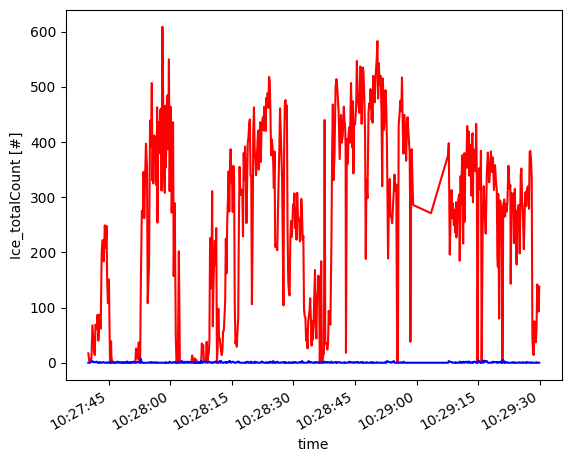

In [5]:
#first_flight.Total_totalCount.isel(time=slice(7500, -3000)).plot(x='time', color='black', alpha=0.5)

start = datetime.datetime(year=2019, month=11, day=12, hour=10, minute=27, second=40)#10000
stop = datetime.datetime(year=2019, month=11, day=12, hour=10, minute=29, second=30)#12000

one = first_flight.Water_totalCount.sel(time=slice(start, stop))
two = first_flight.Ice_totalCount.sel(time=slice(start, stop))
one.plot(x='time', color='red')
two.plot(x='time', color='blue')

In [6]:
print(len(one), float(one.mean()), float(one.std()))
print(len(two), float(two.mean()), float(two.std()))

566 246.76325088339223 169.52547717895771
566 0.5671378091872792 0.8644416111165814


(0.0, 400.0)

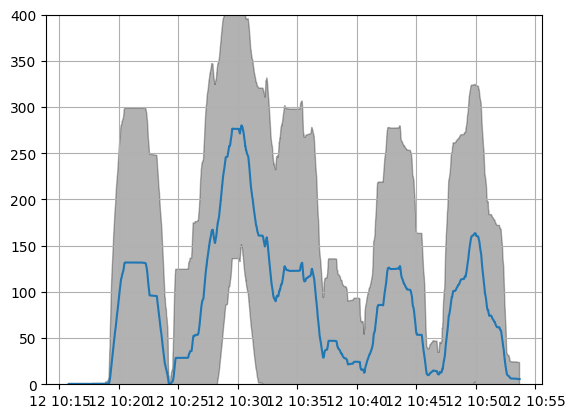

In [7]:
x = first_flight.Water_totalCount.isel(time=slice(6000, -2000)).time
a = first_flight.Water_totalCount.isel(time=slice(6000, -2000)).rolling(time=512*2, center=True)
plt.plot(x, a.mean())
plt.fill_between(x, a.mean() - a.std(), a.mean() + a.std(), color='k', alpha=0.3)
plt.grid()
plt.ylim(0, 400)

In [ ]:
#IWF_first = first_flight.Ice_content / (first_flight.Ice_content + first_flight.Water_content)
#IWF_first.plot.scatter()

In [ ]:
#first_flight['time'] = datenum_to_datetime(first_flight.time.to_numpy())

#plt.hist(first_flight.Ice_meanD * 1000000, density=True, cumulative=True, bins=1000, histtype='step')
plt.hist(first_flight.Water_meanD * 1000000, density=True, cumulative=True, bins=1000, histtype='step')
plt.xlim(5, 45)

In [5]:
start = datetime.datetime(year=2019, month=11, day=12, hour=10, minute=28, second=28)#10000
stop = datetime.datetime(year=2019, month=11, day=12, hour=10, minute=32, second=31)#12000

segment = first_flight.sel(time=slice(start, stop))

In [35]:
def cutoff(data, cutoff_percentage=70):
    mean = data.Water_totalCount.mean()
    return data.where(data.Water_totalCount > mean * cutoff_percentage / 100, other=0)

first_cutoff = cutoff(first_flight) #Need to fully remove holograms with less than cutoff?


(0.0, 3e-05)

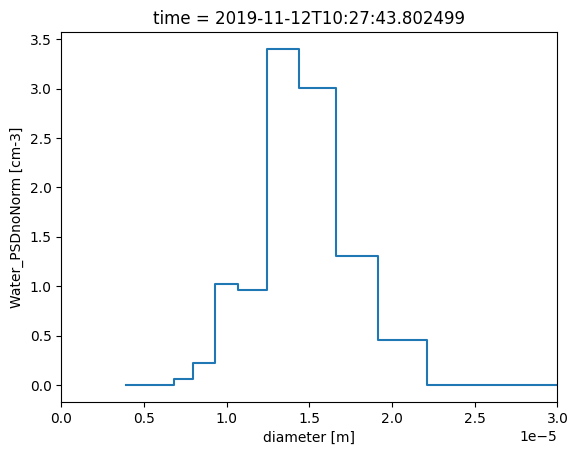

In [36]:
first_flight.Water_PSDnoNorm.isel(time=10000).plot.step(x='diameter')
plt.xlim(0, 0.00003)

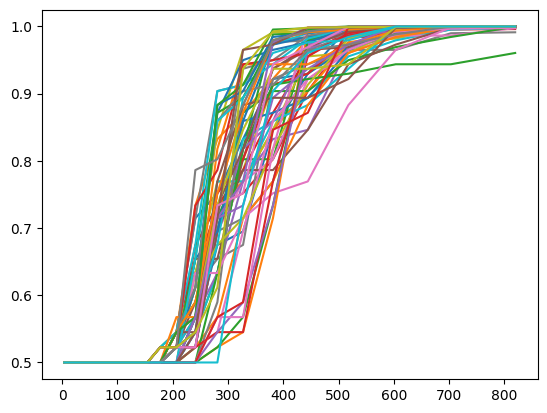

In [84]:
start = datetime.datetime(year=2019, month=11, day=12, hour=10, minute=28, second=28)#10000
stop = datetime.datetime(year=2019, month=11, day=12, hour=10, minute=32, second=31)#11024
segment = first_flight.sel(time=slice(start, stop), diameter=slice(0, 0.0009000))

segment_mean = segment.Water_totalCount.mean()
segment = xr.where(segment.Water_totalCount > segment_mean * 0.7, x=segment, y=np.nan, keep_attrs=True)

for i in range(100):
    cdf = stats.norm.cdf(np.sort(segment.Water_PSDnoNorm.isel(time=i).to_numpy()))
    plt.plot(segment.diameter * 1000000, cdf)

In [81]:
stats.kstest(stats.norm.cdf(np.sort(segment.Water_PSDnoNorm.isel(time=0).to_numpy())),
             stats.norm.cdf(np.sort(segment.Water_PSDnoNorm.isel(time=1).to_numpy())))

KstestResult(statistic=0.02702702702702703, pvalue=1.0)

In [152]:
start = datetime.datetime(year=2019, month=11, day=12, hour=10, minute=28, second=28)#10000
stop = datetime.datetime(year=2019, month=11, day=12, hour=10, minute=32, second=31)#11024
segment = first_flight.sel(time=slice(start, stop)).isel(diameter=slice(2, -18)).copy()

In [81]:
#def resample(segment, thrsh=0.7):
thrsh=0.7
'''
To avoid issues with different number of droplets in each hologram:
    Resample all holograms in the segment to contain the same number of particles.
    All holograms with droplet number below threshold are omitted, whereas all holgrams
    with more droplets than threshold are downsampled to contain thrsh*mean_number number of droplets
'''
lower_cut = int(segment.Water_totalCount.mean() * thrsh)
cut = xr.where(segment.Water_totalCount >= lower_cut, x=segment, y=np.nan).dropna(dim='time', how='all')

number_per_bin = (cut.Water_PSDnoNorm * cut.Total_volume * 100**3)#.astype(int)
n_excess = (cut.Water_totalCount - lower_cut).astype(int)

In [7]:
def cut_segment(segment, threshold):
    lower_cut = segment.Water_totalCount.mean() * threshold
    return xr.where(segment.Water_totalCount >= lower_cut, 
                    x=segment, y=np.nan)#.dropna(dim='time', how='all')

def number_per_bin(data):
    '''Calculate the number of particles in each diameter bin'''
    return data.Water_PSDnoNorm * data.Total_volume * 100**3

def reshape_matrix(hologram):
    '''Reshape the number array to mask matrix for random sampling without replacement'''
    try:
        matrix = np.zeros((len(hologram), int(hologram.max())))
    except ValueError:
        return np.nan
    for i in range(len(hologram)):
        n = int(hologram.isel(diameter=i))
        matrix[i, :n] = np.ones(n)
    return matrix

def resample(matrix, n_excess):
    '''Choose random subset of total droplet number by randomly removing excessive droplets'''
    inds = np.nonzero(matrix)
    rnd = np.random.choice(len(inds[0]), size=int(n_excess), replace=False)
    x, y = inds[0][rnd], inds[1][rnd]
    matrix[x, y] -= 1
    return matrix.sum(axis=1)

def ensemble(hologram, sample_size, n_members=1000):
    '''Create ensemble of samples of size sample_size '''
    
    droplet_numbers = number_per_bin(hologram)
    n_excess = (droplet_numbers.sum() - sample_size).astype(int)
    matrix = reshape_matrix(droplet_numbers)
    try:
        return np.array([resample(matrix.copy(), n_excess) for _ in range(n_members)])
    except AttributeError:
        return np.array([[np.nan] * len(droplet_numbers)] * n_members)
    
def KS(dist1, dist2):
    return stats.kstest(dist1, dist2).statistic

In [31]:
n_holograms = len(segment.time)
n_members = 10

cut = cut_segment(segment, 0.7)
n_bins = len(cut.diameter)

#all_times = np.zeros((n_holograms, n_members, n_bins))


def create_ensembles(t):
    #for t in range(0, n_holograms):
    #all_times[t, :, :] = 
    return ensemble(cut.isel(time=t), 
                sample_size=int(segment.Water_totalCount.mean() * 0.7), 
                n_members=n_members)
with tqdm_joblib('Progress', total=n_holograms) as progress_bar:
    all_times = np.array(Parallel(n_jobs=-2)(delayed(create_ensembles)(t) for t in range(n_holograms)))

100%|██████████| 1024/1024 [01:44<00:00,  9.78it/s]


In [32]:
def f(h):
    KS_row = np.zeros(n_holograms)
    primary_holo = all_times[h]

    if np.isnan(primary_holo).any():
        KS_row[:] *= np.nan
        pass
    
    for primary_ent in primary_holo:
        for t, secondary_holo in enumerate(all_times[:]):
            if np.isnan(secondary_holo).any():
                KS_row[t] *= np.nan
                pass
            for secondary_ent in secondary_holo:
                KS_row[t] += KS(primary_ent, secondary_ent)
    return KS_row

with tqdm_joblib('Progress', total=n_holograms) as progress_bar:
    KS_matrix = np.array(Parallel(n_jobs=-2)(delayed(f)(h) for h in range(n_holograms))) / n_members**2

100%|██████████| 1024/1024 [25:03<00:00,  1.47s/it]


In [33]:
np.save('KS_matrix_seg1_1024H_10members.npy', KS_matrix)

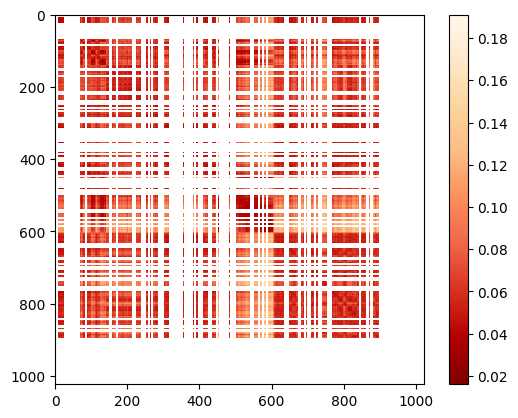

In [34]:
X, Y = np.meshgrid(range(n_holograms), range(n_holograms))
plt.imshow(KS_matrix, cmap='OrRd_r')#(X, Y, c=KS_matrix)
plt.colorbar()

In [327]:
KS_matrix

array([[0.0672, 0.0764, 0.0836, 0.0936, 1.    , 1.    , 1.    , 0.1104,
        0.0936, 0.1036],
       [0.0764, 0.056 , 0.0864, 0.0776, 1.    , 1.    , 1.    , 0.0848,
        0.0712, 0.0764],
       [0.0836, 0.0864, 0.0528, 0.1032, 1.    , 1.    , 1.    , 0.0984,
        0.0872, 0.0688],
       [0.0936, 0.0776, 0.1032, 0.0624, 1.    , 1.    , 1.    , 0.0832,
        0.0716, 0.0788],
       [1.    , 1.    , 1.    , 1.    , 0.    , 0.    , 0.    , 1.    ,
        1.    , 1.    ],
       [1.    , 1.    , 1.    , 1.    , 0.    , 0.    , 0.    , 1.    ,
        1.    , 1.    ],
       [1.    , 1.    , 1.    , 1.    , 0.    , 0.    , 0.    , 1.    ,
        1.    , 1.    ],
       [0.1104, 0.0848, 0.0984, 0.0832, 1.    , 1.    , 1.    , 0.0592,
        0.0772, 0.0816],
       [0.0936, 0.0712, 0.0872, 0.0716, 1.    , 1.    , 1.    , 0.0772,
        0.0456, 0.0596],
       [0.1036, 0.0764, 0.0688, 0.0788, 1.    , 1.    , 1.    , 0.0816,
        0.0596, 0.0552]])

In [299]:
ks = 0
for i in range(1000):
    ks += stats.kstest(all_times[4][0], all_times[99][i]).statistic
ks / 1000

1.0

In [335]:
np.isnan(all_times[4]).any()

True

In [355]:
stats.kstest(all_times[0], all_times[1])

ValueError: object too deep for desired array

(5.0, 30.0)

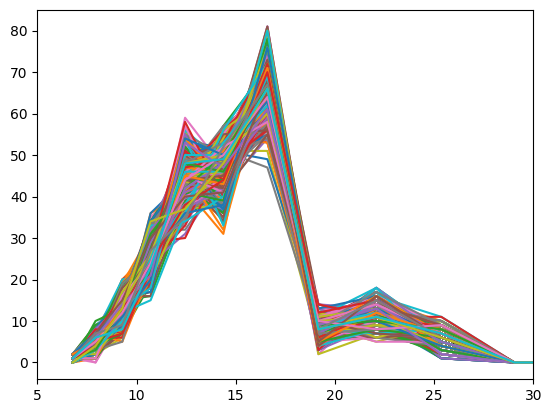

In [207]:
for n in ens:
    plt.plot(cut.diameter*1000000, n)
plt.xlim(5, 30)

In [83]:
ensemble = []
for i in range(100):
    ent = test.copy()
    for _ in range(int(n_excess.isel(time=0))):
        ind = np.random.choice(len(ent.diameter), p=ent / ent.sum())
        ent[ind] -= 1
    ensemble.append(ent.to_numpy())
print(ensemble)

[array([ 0.,  1.,  1.,  5.,  2.,  4.,  8., 16., 42.,  8.,  1.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]), array([ 0.,  0.,  2.,  4.,  5.,  4.,  7., 21., 36.,  9.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]), array([ 0.,  0.,  2.,  4.,  3.,  3.,  5., 16., 48.,  7.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  6.,  1.,  4.,  7., 15., 47.,  8.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  4.,  5.,  1.,  7., 22., 39.,  8.,  2.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]), array([ 0.,  0.,  1.,  4.,  4.,  4.,  9., 20., 37.,  9.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]), array([ 0.,  2.,  1.,  4.,  2.,  7.,  6., 18., 37., 11.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]), array([ 0., 

In [110]:
# Algorithm

# Step 1
segment = find_segment()

# Step 2
segment_cut = cutoff()

# Step 3
KS_matrix = KS_test()

    # Step 3.1
    ensemble


In [167]:
cls = cluster.DBSCAN(eps=0.1, min_samples=10)



In [50]:
first_flight.Total_volume.isel(time=10000).to_numpy() * 100**3

17.640000000000004

In [76]:
len(first_flight.time)

20722

In [88]:
def f(t):
    fig, ax = plt.subplots(1, 2, figsize=(8,3))
    nl = first_flight.Water_PSDnoNorm.isel(time=t).to_numpy() * \
        first_flight.Total_volume.isel(time=t).to_numpy() * 100**3
    ax[0].bar(first_flight.diameter * 1000000, nl)
    ax[0].set_xlim(6, 30)
    ax[0].set_ylim(0, 60)
    ni = first_flight.Ice_PSDnoNorm.isel(time=t).to_numpy() * \
        first_flight.Total_volume.isel(time=t).to_numpy() * 100**3
    ax[1].bar(first_flight.diameter * 1000000, ni)
    ax[1].set_xlim(6, 500)
    ax[1].set_ylim(0, 10)


interact(f, t=IntSlider(min=9000, max=len(first_flight.time)))

interactive(children=(IntSlider(value=9000, description='t', max=20722, min=9000), Output()), _dom_classes=('w…

<function __main__.f(t)>

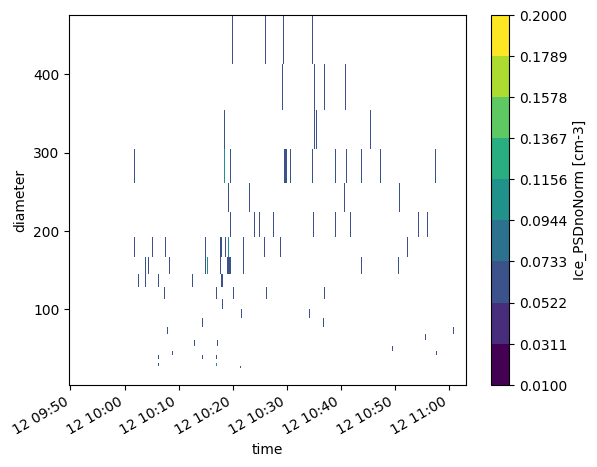

In [102]:
ni = first_flight.Ice_PSDnoNorm.sel(diameter=slice(0, 0.0005))# * \
    #first_flight.Total_volume * 100**3
ni['diameter'] = ni.diameter * 1000000
ni.plot(levels=np.linspace(0.01, 0.20, 10), extend='neither')
